In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=efe3bbe8738a273821b97f228a69cf8bce7f883b585cb56731d55399f0b7b2b4
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark import SparkConf , SparkContext
import collections
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier

In [27]:
conf = SparkConf().setMaster('local').setAppName('RatingsHistogram')
sc = SparkContext(conf=conf)

In [28]:
# Initialize a Spark session
spark = SparkSession.builder.appName("ChurnClassification").getOrCreate()


In [29]:
# Load the dataset
data = spark.read.csv("churn.csv", header=True, inferSchema=True)

In [ ]:
data.show()

+---+-------------------+----+--------------+---------------+-----+---------+-----+
|_c0|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+-------------------+----+--------------+---------------+-----+---------+-----+
|  0|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|      Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|     Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
|  5|   Jessica Williams|48.0|      10356.02|              0| 5.12|      8.0|    1|
|  6|        Eric Butler|44.0|      11331.58|              1| 5.23|     11.0|    1|
|  7|      Zachary Walsh|32.0|       9885.12|              1| 6.92|      9.0|    1|
|  8|        Ashlee Carr|43.0|       14062.6|              1| 5.46|     11.0

In [30]:
pd_df = data.toPandas()

In [21]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

In [22]:
# Define the feature columns and label column
feature_cols = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"]
label_col = "Churn"

# Assemble the feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data.select(*feature_cols, label_col))
test_data = assembler.transform(test_data.select(*feature_cols, label_col))


<ipython-input-33-b21ca96e9321>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(pd_df[f],
<ipython-input-33-b21ca96e9321>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(pd_df[f],
<ipython-input-33-b21ca96e9321>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

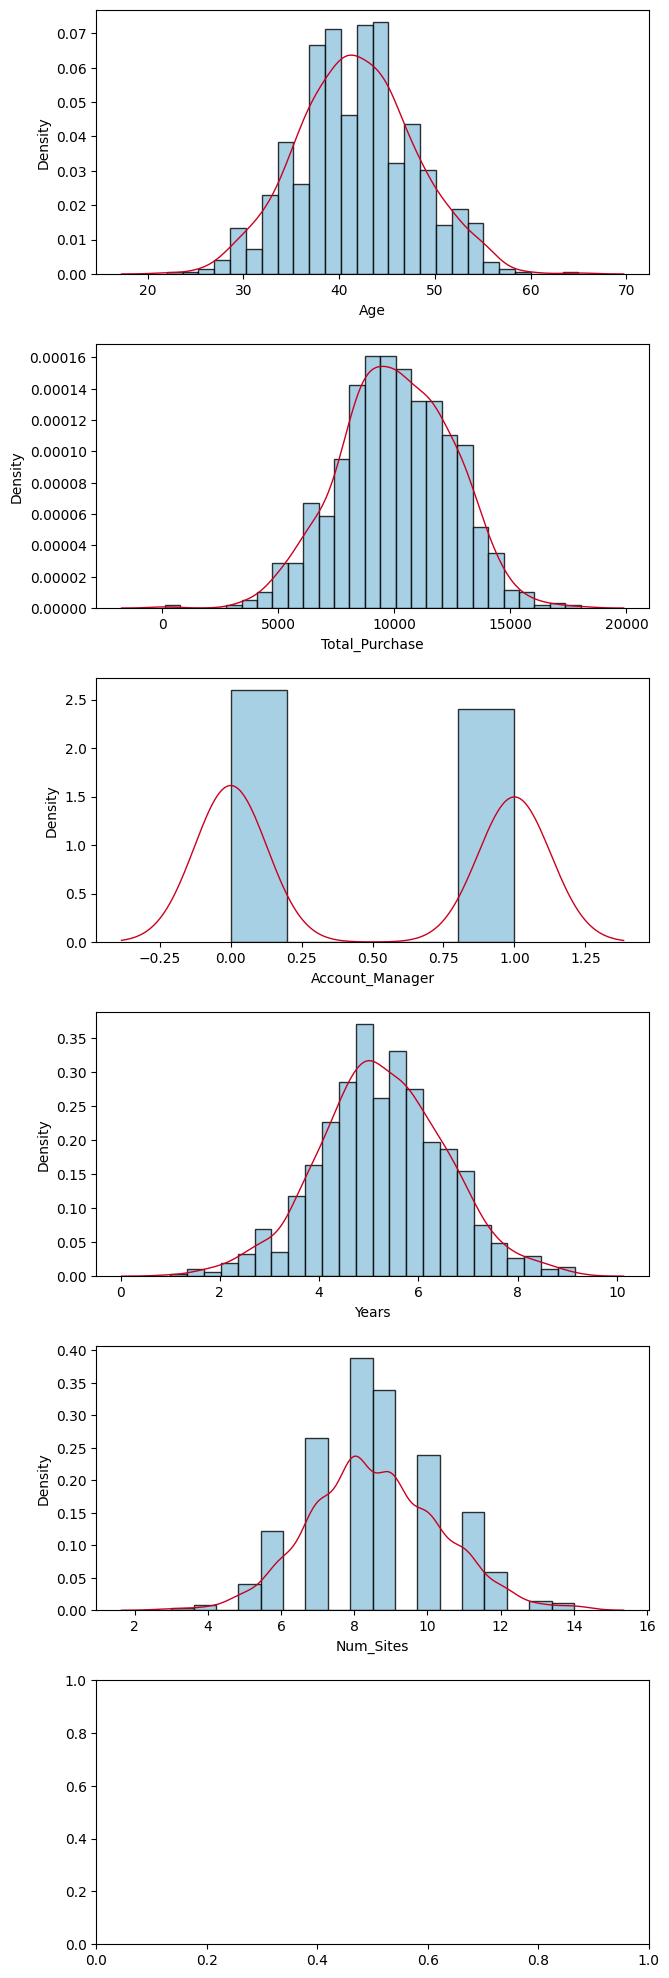

In [33]:
# Her sütunun değerlerinin dağılımının çizilmesi

n_rows = 6
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7,20));

for i,f in enumerate(feature_cols):
    _ = sns.distplot(pd_df[f],
                    kde_kws={"color": "#ca0020", "lw": 1},
                    hist_kws={"histtype": "bar", "edgecolor": "k", "linewidth": 1,"alpha": 0.8, "color": "#92c5de"},
                    ax=axes[i]
                    );

fig.tight_layout(pad=1.5);

In [23]:
# Create and train a Logistic Regression model
GBC = GBTClassifier(labelCol=label_col, featuresCol="features")
model = GBC.fit(train_data)

In [24]:
# Make predictions on the testing data
predictions = model.transform(test_data)

# Evaluate the model's performance using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=label_col)
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.887931034482759


In [25]:
# Stop the Spark session
spark.stop()